# sin control variate for RMC
Polynomials are the most obvious order correcting CVs but that doesn't mean they are the best choice. This is an example to demonstrate you can use trig functions to do order correction which may have better extrapolation properties. 

Lets look at an example:
$$
y'=y, y(0)=1.
$$ 
integral equation (this is stable):
$$
y(t)= y(T) + \int_{T}^{t} y(s)ds.
$$ 
Now we need to correct $y(s)$ up to first order information:
$$
y(s) \approx c + b \sin(s-T).
$$ 
with Taylor it can be found that $c=b=y(T)$ correct up to first order. Then integrating the CV:
$$
\int_{T}^{t} y(T) + y(T) \sin(s-T) ds = y(T) (1 + t-T-\cos(t-T)) .
$$ 
 





In [1]:

from random import random
from math import exp,pow,cos,sin
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    sol = yT*(2 + t-T - cos(t-T)) # vs  yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    l = 10 # russian roulette rate l>1
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  #\sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, DT) -yT*(1+sin(S-T))) #vs -yT*(1+S-T)
    return sol 

@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1.0,0.0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

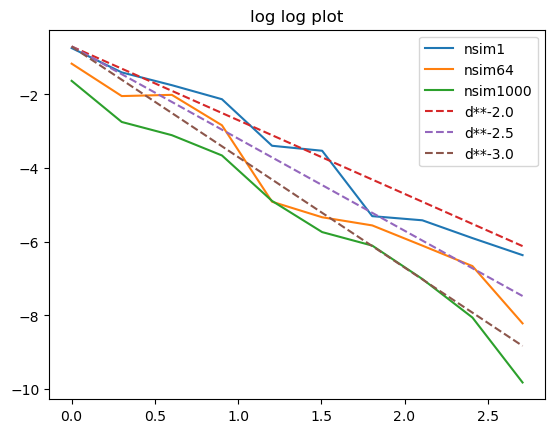

In [2]:

def CVRRMC_llplt():
    T = 2
    DTS = np.power(0.5,np.array(range(10)))
    Ns = [1,64,1000]
    for nsim in Ns:
        errors = np.array([(abs(solX(T, d, nsim )-exp(T)))/(exp(T)) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = f"nsim{nsim}")

    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(ref/5)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

CVRRMC_llplt()

Comparing this convergence plot with 